In [1]:
import numpy as np
import multiprocessing
import matplotlib.pyplot as plt
import scipy.optimize as opt
from mpl_toolkits.axes_grid1 import make_axes_locatable
import pandas as pd
from autogluon.tabular import TabularPredictor

In [2]:
def LIMA(alpha, Non, Noff):
    sig = np.sqrt(2) * np.sqrt(
        Non * np.log((1 + alpha) / alpha * (Non / (Non + Noff)))
        + Noff * np.log((1 + alpha) * Noff / (Non + Noff))
    )
    if type(sig) is np.ndarray:
        sig[np.where((Non - Noff * alpha) < 0)] = -sig[
            np.where((Non - Noff * alpha) < 0)
        ]
    else:
        if (Non - Noff * alpha) < 0:
            sig = -sig
    sig[np.isnan(sig)]=0
    return sig

In [3]:
para_num=6
predictor_gamma_CR = TabularPredictor.load(
    f"/home2/hky/github/Gamma_Energy/AllSky_withCR/agmodel/identitfy_gamma_CR_{para_num}par_mulitysource"
)

In [29]:
cx = np.linspace(-150,150,601)
cy = np.linspace(-150,150,601)
x,y=np.meshgrid(cx,cy)

In [30]:
x_=x.reshape(-1)
y_=y.reshape(-1)
summd = np.full_like(x_,2)
sumpf = np.full_like(x_,100)

In [31]:
df = pd.DataFrame({"cx":x_,"cy":y_,"summd":summd,"sumpf":sumpf})

In [32]:
df["isgamma"]=predictor_gamma_CR.predict_proba(df)[1]

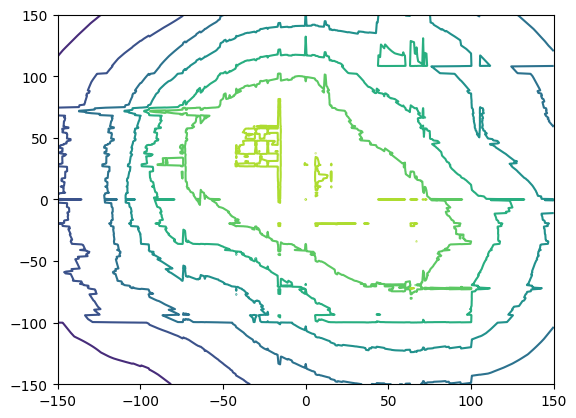

In [33]:
plt.contour(x, y, df["isgamma"].to_numpy().reshape(x.shape))


In [4]:
Exptdata = np.load(
    "/home2/hky/github/Gamma_Energy/Exptdata/CrabCut_23_05_07_summdcut/cutedData_E_isgamma_RaDec.npz"
)
Exptdata = {key: Exptdata[key]for key in Exptdata}

In [5]:
mjd = Exptdata["mjd"]
Exptdata["mjd"] = np.round(Exptdata["mjd"]/30)


In [9]:
Exptdata[f"isgamma_{para_num}"] =predictor_gamma_CR.predict_proba(pd.DataFrame(Exptdata))[1].to_numpy()

In [10]:
Exptdata["mjd"] = mjd

In [11]:
np.savez("/home2/hky/github/Gamma_Energy/Exptdata/CrabCut_23_05_07_summdcut/cutedData_E_isgamma_RaDec.npz", **Exptdata)

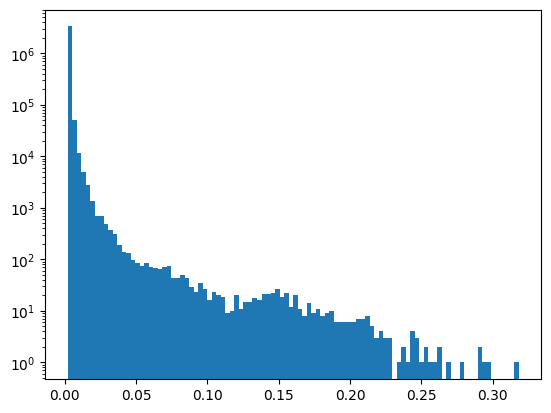

In [16]:
plt.hist(Exptdata[f"isgamma_{para_num}"][Exptdata["energy"] > 100],bins=100)
plt.yscale("log")
plt.show()

In [17]:
import healpy as hp
NSIDE = 2**9
NPIX = hp.nside2npix(NSIDE)

In [18]:
isgammaminlist = np.linspace(0.01,0,21)
hpmap_All = np.zeros(NPIX)
hpmap_Background = np.zeros(NPIX)
energymin = 10
data_need = np.where(
    (Exptdata["energy"] > energymin)
    & (Exptdata[f"isgamma_{para_num}"] > isgammaminlist[0])
)
np.add.at(
    hpmap_All,
    hp.ang2pix(
        NSIDE,
        Exptdata["Ra"][data_need],
        Exptdata["Dec"][data_need],
        lonlat=True,
    ),
    1,
)
for i in range(20):
    np.add.at(
        hpmap_Background,
        hp.ang2pix(
            NSIDE,
            Exptdata[f"RaOff_{i}"][data_need],
            Exptdata[f"DecOff_{i}"][data_need],
            lonlat=True,
        ),
        1,
    )
for isgammamin_i in range(1, len(isgammaminlist)):
    data_need = np.where(
        (Exptdata["energy"] > energymin)
        & (Exptdata[f"isgamma_{para_num}"] > isgammaminlist[isgammamin_i])
        & (Exptdata[f"isgamma_{para_num}"] < isgammaminlist[isgammamin_i - 1])
    )
    np.add.at(
        hpmap_All,
        hp.ang2pix(
            NSIDE,
            Exptdata["Ra"][data_need],
            Exptdata["Dec"][data_need],
            lonlat=True,
        ),
        1,
    )
    for i in range(20):
        np.add.at(
            hpmap_Background,
            hp.ang2pix(
                NSIDE,
                Exptdata[f"RaOff_{i}"][data_need],
                Exptdata[f"DecOff_{i}"][data_need],
                lonlat=True,
            ),
            1,
        )
    fwhm = np.deg2rad(0.8)
    hpmap_All_gaus_smoothed = hp.smoothing(hpmap_All, fwhm=fwhm)
    hpmap_background_gaus_smoothed = hp.smoothing(hpmap_Background, fwhm=fwhm)
    sigma = LIMA(0.05, hpmap_All_gaus_smoothed, hpmap_background_gaus_smoothed)
    sigma /= np.std(sigma[hpmap_All != 0])
    print(
        isgammaminlist[isgammamin_i],
        np.max(
            sigma
        ),
    )

# [
#                 hp.query_disc(
#                     NSIDE, hp.ang2vec(284.57, 2.06, lonlat=True), np.deg2rad(1)
#                 )
#             ]

/tmp/ipykernel_2029219/2013940310.py:3: RuntimeWarning: divide by zero encountered in divide
  Non * np.log((1 + alpha) / alpha * (Non / (Non + Noff)))
/tmp/ipykernel_2029219/2013940310.py:3: RuntimeWarning: invalid value encountered in divide
  Non * np.log((1 + alpha) / alpha * (Non / (Non + Noff)))
/tmp/ipykernel_2029219/2013940310.py:3: RuntimeWarning: divide by zero encountered in log
  Non * np.log((1 + alpha) / alpha * (Non / (Non + Noff)))
/tmp/ipykernel_2029219/2013940310.py:3: RuntimeWarning: invalid value encountered in log
  Non * np.log((1 + alpha) / alpha * (Non / (Non + Noff)))
/tmp/ipykernel_2029219/2013940310.py:3: RuntimeWarning: invalid value encountered in multiply
  Non * np.log((1 + alpha) / alpha * (Non / (Non + Noff)))
/tmp/ipykernel_2029219/2013940310.py:4: RuntimeWarning: divide by zero encountered in divide
  + Noff * np.log((1 + alpha) * Noff / (Non + Noff))
/tmp/ipykernel_2029219/2013940310.py:4: RuntimeWarning: invalid value encountered in divide
  + Noff 

0.0095 24.385881420933146
0.009000000000000001 26.099189476870098
0.0085 28.17280932162922
0.008 30.54720903257908
0.0075 33.30699223536561
0.007 36.27707220859408
0.006500000000000001 39.17718675388151
0.006 42.218665770258426
0.0055 45.25979388298613
0.005 48.62380777574886
0.0045000000000000005 51.954390123760994
0.004 53.563841367772966
0.0034999999999999996 44.17209849092684


KeyboardInterrupt: 

In [38]:
isgammamin = 0.004
hpmap_All = np.zeros(NPIX)
hpmap_Background = np.zeros(NPIX)
energymin = 10
data_need = np.where(
    (Exptdata["energy"] > energymin) & (Exptdata[f"isgamma_{para_num}"] > isgammamin)
)
np.add.at(
    hpmap_All,
    hp.ang2pix(
        NSIDE,
        Exptdata["Ra"][data_need],
        Exptdata["Dec"][data_need],
        lonlat=True,
    ),
    1,
)
for i in range(20):
    np.add.at(
        hpmap_Background,
        hp.ang2pix(
            NSIDE,
            Exptdata[f"RaOff_{i}"][data_need],
            Exptdata[f"DecOff_{i}"][data_need],
            lonlat=True,
        ),
        1,
    )

fwhm = np.deg2rad(0.5)
hpmap_All_gaus_smoothed = hp.smoothing(hpmap_All, fwhm=fwhm)
hpmap_background_gaus_smoothed = hp.smoothing(hpmap_Background, fwhm=fwhm)
sigma = LIMA(0.05, hpmap_All_gaus_smoothed, hpmap_background_gaus_smoothed)
std = np.std(sigma[(hpmap_All != 0)])
std = np.std(sigma[(hpmap_All != 0)&(np.abs(sigma)<5*std)])
sigma /= std
print(np.max(sigma))


61.93249333754636


/tmp/ipykernel_2029219/2013940310.py:3: RuntimeWarning: invalid value encountered in log
  Non * np.log((1 + alpha) / alpha * (Non / (Non + Noff)))
/tmp/ipykernel_2029219/2013940310.py:4: RuntimeWarning: invalid value encountered in log
  + Noff * np.log((1 + alpha) * Noff / (Non + Noff))
/tmp/ipykernel_2029219/2013940310.py:2: RuntimeWarning: invalid value encountered in sqrt
  sig = np.sqrt(2) * np.sqrt(


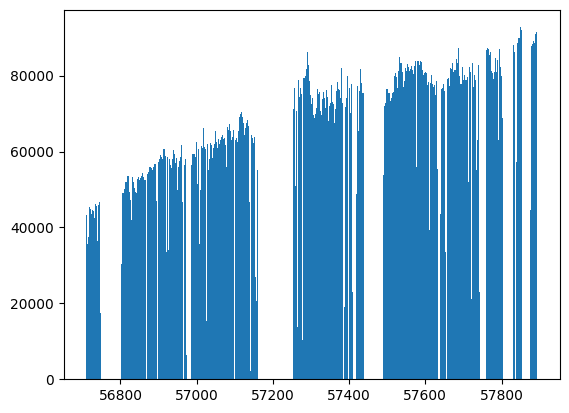

In [49]:
plt.hist(Exptdata["mjd"],bins=np.linspace(56710,57893,57893-56710+1))
plt.show()

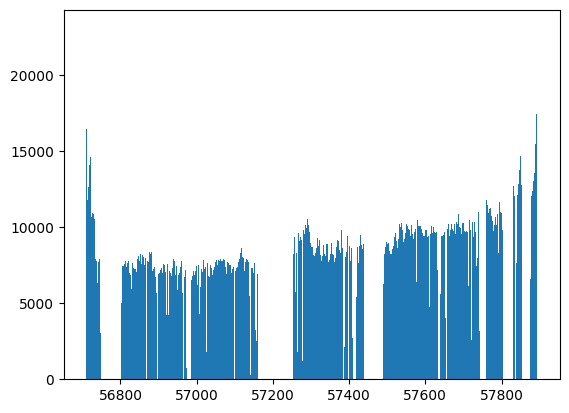

In [53]:
plt.hist(Exptdata["mjd"][Exptdata["isgamma_6"]>0.0035],bins=np.linspace(56710,57893,57893-56710+1))
plt.show()

In [25]:
sigma[sigma<4]=0

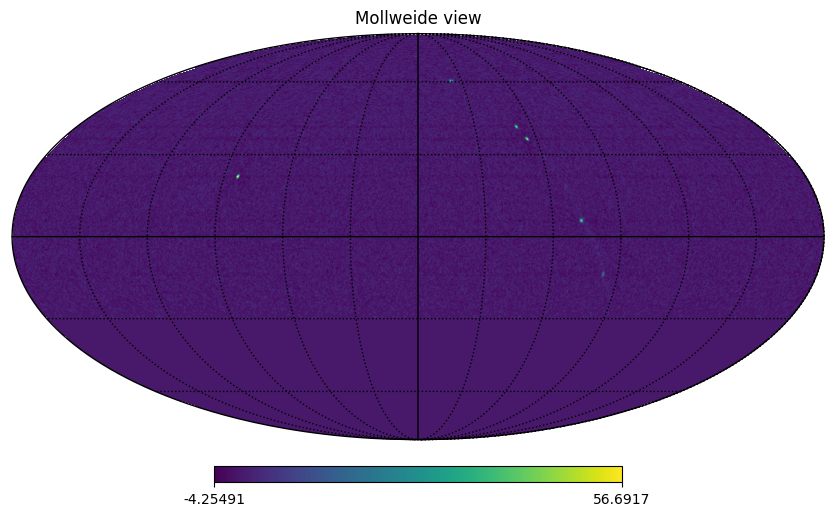

In [39]:
hp.mollview(sigma)
hp.graticule()

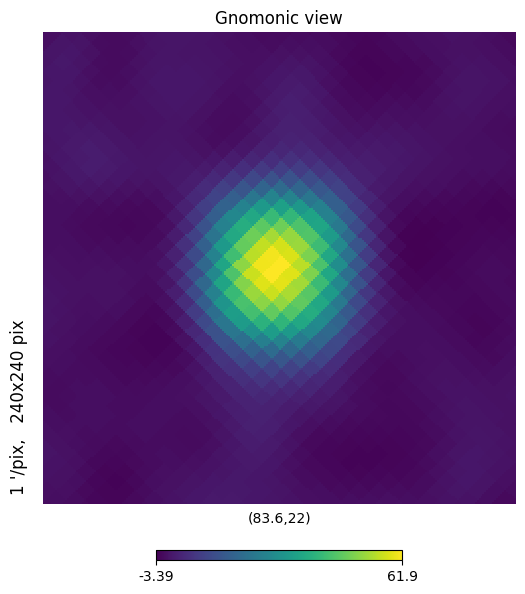

In [42]:
drawdeg = 2
reso = 1
hp.gnomview(
    sigma,
    rot=[83.6, 22],
    xsize=drawdeg * 60 / reso * 2,
    reso=reso,
)


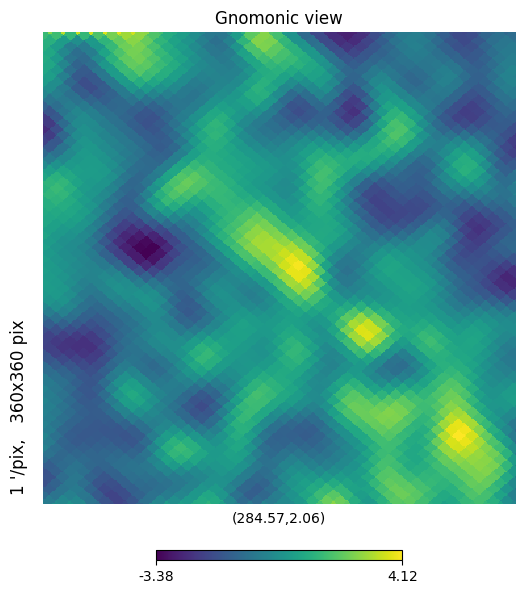

In [46]:
drawdeg = 3
reso = 1
hp.gnomview(
    sigma,
    rot=[284.57, 2.06],
    xsize=drawdeg * 60 / reso * 2,
    reso=reso,
)


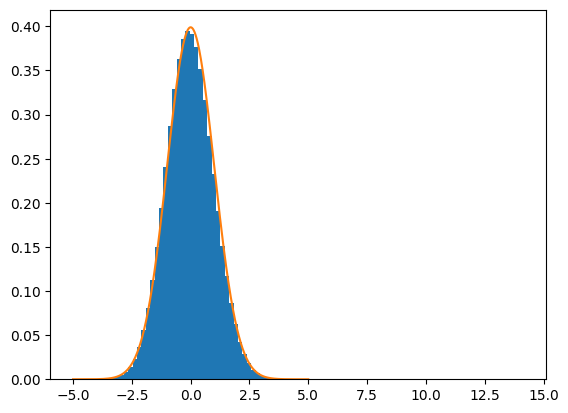

In [44]:
# hist,_=np.histogram(sigma[hpmap_All!=0],bins=100)
# sigma_gaus = fwhm / (2.0 * np.sqrt(2.0 * np.log(2.0)))
plt.hist(sigma[hpmap_All!=0],density=True,bins=100)
x=np.linspace(-5,5,1000)
y=1/np.sqrt(2*np.pi)*np.exp(-x**2/2)
plt.plot(x,y)
plt.show()

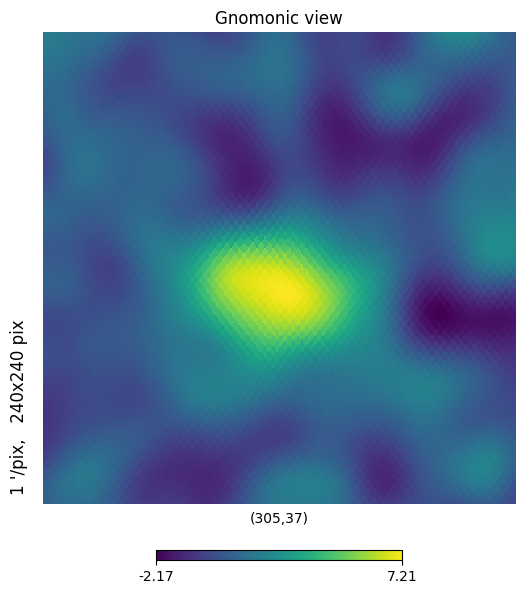

In [47]:
drawdeg = 2
reso = 1
hp.gnomview(
    sigma,
    rot=[305, 37],
    xsize=drawdeg * 60 / reso * 2,
    reso=reso,
)


In [40]:
hpmap_All_smoothed = np.zeros_like(hpmap_All)
hpmap_Background_smoothed = np.zeros_like(hpmap_All)
pixlenlist = list()
for i in range(NPIX):
    pix_need = hp.query_disc(NSIDE, hp.pix2vec(NSIDE, i), np.deg2rad(0.5))
    hpmap_All_smoothed[i] = np.sum(hpmap_All[pix_need])
    hpmap_Background_smoothed[i] = np.sum(hpmap_Background[pix_need])

In [18]:
len(Exptdata["sumpf"])

50093737

In [19]:
np.argmax(hpmap_All_smoothed)

625352

/tmp/ipykernel_6938/2013940310.py:3: RuntimeWarning: invalid value encountered in divide
  Non * np.log((1 + alpha) / alpha * (Non / (Non + Noff)))
/tmp/ipykernel_6938/2013940310.py:3: RuntimeWarning: divide by zero encountered in log
  Non * np.log((1 + alpha) / alpha * (Non / (Non + Noff)))
/tmp/ipykernel_6938/2013940310.py:3: RuntimeWarning: invalid value encountered in multiply
  Non * np.log((1 + alpha) / alpha * (Non / (Non + Noff)))
/tmp/ipykernel_6938/2013940310.py:4: RuntimeWarning: invalid value encountered in divide
  + Noff * np.log((1 + alpha) * Noff / (Non + Noff))
/tmp/ipykernel_6938/2013940310.py:4: RuntimeWarning: divide by zero encountered in log
  + Noff * np.log((1 + alpha) * Noff / (Non + Noff))
/tmp/ipykernel_6938/2013940310.py:4: RuntimeWarning: invalid value encountered in multiply
  + Noff * np.log((1 + alpha) * Noff / (Non + Noff))


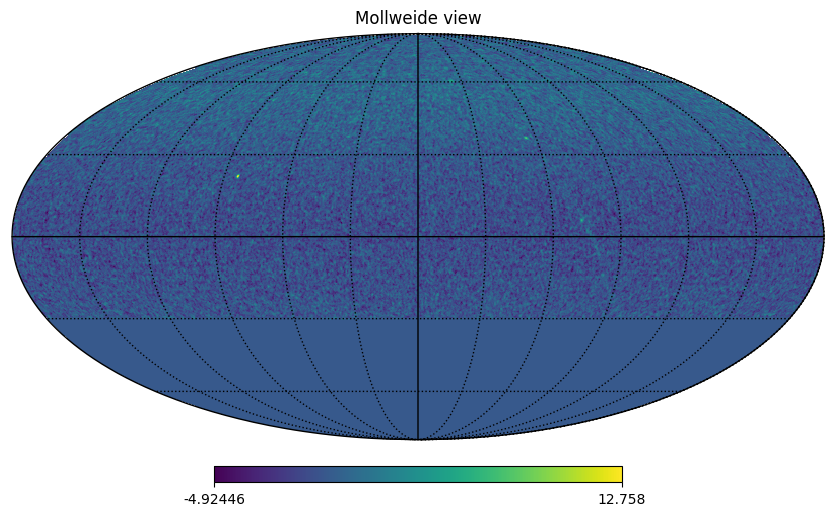

In [20]:
sigma=LIMA(0.05,hpmap_All_smoothed,hpmap_Background_smoothed)
hp.mollview(sigma)
hp.graticule()

In [21]:
np.argmax(hpmap_All_smoothed-hpmap_Background_smoothed/20)

978395

In [24]:
hp.pix2ang(NSIDE, np.argmax(hpmap_All_smoothed), lonlat=True)


(305.15625, 37.07533498237023)

In [11]:
arg=np.argmax(hpmap_All_smoothed-hpmap_Background_smoothed/20)

print("On:",hpmap_All_smoothed[arg])
print("Off:",hpmap_Background_smoothed[arg])
print("Over:",hpmap_All_smoothed[arg]-hpmap_Background_smoothed[arg]/20)

On: 2538.0
Off: 37432.0
Over: 666.4000000000001


/tmp/ipykernel_3334/2013940310.py:3: RuntimeWarning: invalid value encountered in divide
  Non * np.log((1 + alpha) / alpha * (Non / (Non + Noff)))
/tmp/ipykernel_3334/2013940310.py:3: RuntimeWarning: divide by zero encountered in log
  Non * np.log((1 + alpha) / alpha * (Non / (Non + Noff)))
/tmp/ipykernel_3334/2013940310.py:3: RuntimeWarning: invalid value encountered in multiply
  Non * np.log((1 + alpha) / alpha * (Non / (Non + Noff)))
/tmp/ipykernel_3334/2013940310.py:4: RuntimeWarning: invalid value encountered in divide
  + Noff * np.log((1 + alpha) * Noff / (Non + Noff))
/tmp/ipykernel_3334/2013940310.py:4: RuntimeWarning: divide by zero encountered in log
  + Noff * np.log((1 + alpha) * Noff / (Non + Noff))
/tmp/ipykernel_3334/2013940310.py:4: RuntimeWarning: invalid value encountered in multiply
  + Noff * np.log((1 + alpha) * Noff / (Non + Noff))


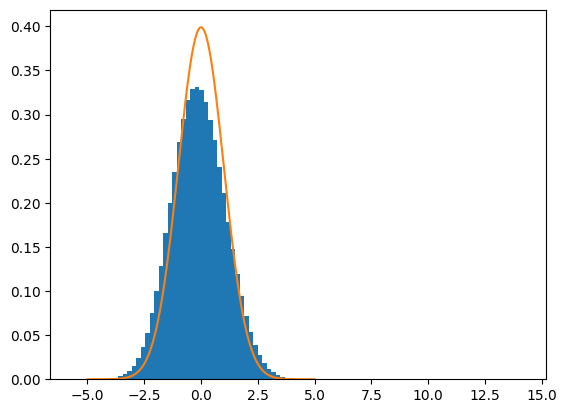

In [23]:
sigma=LIMA(0.05,hpmap_All_smoothed,hpmap_Background_smoothed)
plt.hist(sigma[hpmap_All!=0],density=True,bins=100)
x=np.linspace(-5,5,1000)
y=1/np.sqrt(2*np.pi)*np.exp(-x**2/2)
plt.plot(x,y)
plt.show()

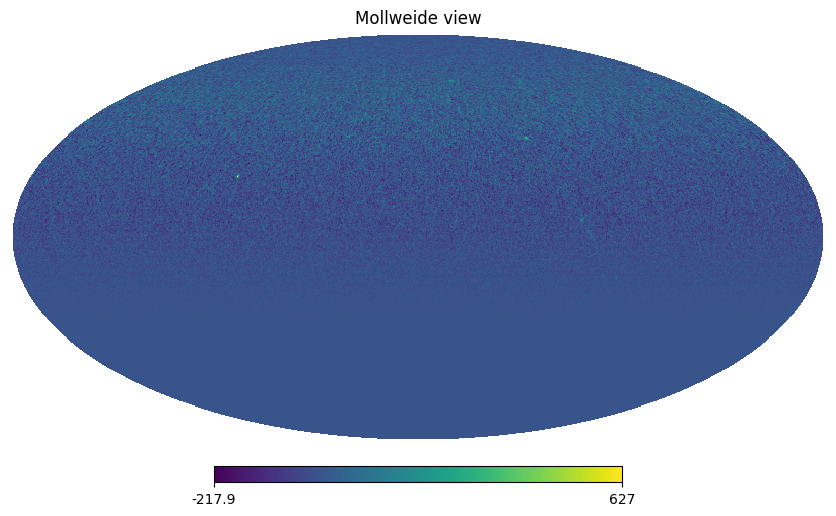

In [46]:
hp.mollview(hpmap_All_smoothed-hpmap_Background_smoothed/20)

In [46]:
import healpy as hp

NSIDE = 2**9
NPIX = hp.nside2npix(NSIDE)
for isgammamin in [0.01, 0.05, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8]:
    for energymin in [10, 25, 50, 100]:
        hpmap = np.zeros(NPIX)
        np.add.at(
            hpmap,
            hp.ang2pix(
                NSIDE,
                Exptdata["Ra"][
                    np.where(
                        (Exptdata["isgamma"] > isgammamin)
                        & (Exptdata["energy"] > energymin)
                    )
                ],
                Exptdata["Dec"][
                    np.where(
                        (Exptdata["isgamma"] > isgammamin)
                        & (Exptdata["energy"] > energymin)
                    )
                ],
                lonlat=True,
            ),
            1,
        )
        hpmap_smoothed = np.zeros(NPIX)
        pixlist = hp.query_strip(NSIDE, np.deg2rad(90 - 27), np.deg2rad(90 - 17))
        for i in pixlist:
            hpmap_smoothed[i] = np.sum(
                hpmap[hp.query_disc(NSIDE, hp.pix2vec(NSIDE, i), np.deg2rad(0.5))]
            )
        hpmap_smoothed_copy = hpmap_smoothed.copy()
        hpmap_smoothed_background = np.zeros_like(hpmap_smoothed)
        hpmap_smoothed_copy[
            hp.query_disc(NSIDE, hp.ang2vec(83.6, 22, lonlat=True), np.deg2rad(2))
        ] = 0
        sigma = np.zeros(NPIX)
        for theta in np.linspace(22 - 4, 22 + 4, 81):
            pix = hp.query_strip(
                NSIDE, np.deg2rad(90 - theta - 0.1), np.deg2rad(90 - theta)
            )
            # print(hpmap_smoothed_copy[pix][np.where(hpmap_smoothed_copy[pix]!=0)])
            hpmap_smoothed_background[pix] = np.mean(
                hpmap_smoothed_copy[pix][np.where(hpmap_smoothed_copy[pix] != 0)]
            )
            rate = 1 / len(pix)
            sigma[pix] = LIMA(
                rate,
                hpmap_smoothed[pix],
                hpmap_smoothed_background[pix] / rate,
            )
        sigma[np.isnan(sigma)] = 0
        hp.gnomview(
            sigma,
            rot=[83.6, 22],
            xsize=3 * 2 * 10,
            reso=6,
        )
        plt.title(
            f"gammacut:{isgammamin:.2f} energymin:{energymin} significant {np.max(sigma):.2f}$\sigma$"
        )
        plt.savefig(
            f"/home2/hky/github/Gamma_Energy/AllSky_withCR/fig/Crab/significant/{isgammamin:.2f}_{energymin}_{np.max(sigma):.2f}_significant.png"
        )
        plt.close()
        hp.gnomview(
            hpmap_smoothed - hpmap_smoothed_background,
            rot=[83.6, 22],
            xsize=3 * 2 * 10,
            reso=6,
        )
        plt.title(f"gammacut:{isgammamin:.2f} energymin:{energymin} over")
        plt.savefig(
            f"/home2/hky/github/Gamma_Energy/AllSky_withCR/fig/Crab/Over/{isgammamin:.2f}_{energymin}_Over.png"
        )
        plt.close()


/tmp/ipykernel_2075388/2091761696.py:3: RuntimeWarning: divide by zero encountered in log
  Non * np.log((1 + alpha) / alpha * (Non / (Non + Noff)))
/tmp/ipykernel_2075388/2091761696.py:3: RuntimeWarning: invalid value encountered in multiply
  Non * np.log((1 + alpha) / alpha * (Non / (Non + Noff)))


In [9]:
def twoD_Gaussian(xdata_tuple, amplitude, xo, yo, sigma_x, sigma_y, theta, offset):
    (x, y) = xdata_tuple
    xo = float(xo)
    yo = float(yo)
    a = (np.cos(theta) ** 2) / (2 * sigma_x**2) + (np.sin(theta) ** 2) / (
        2 * sigma_y**2
    )
    b = -(np.sin(2 * theta)) / (4 * sigma_x**2) + (np.sin(2 * theta)) / (
        4 * sigma_y**2
    )
    c = (np.sin(theta) ** 2) / (2 * sigma_x**2) + (np.cos(theta) ** 2) / (
        2 * sigma_y**2
    )
    g = offset + amplitude * np.exp(
        -(a * ((x - xo) ** 2) + 2 * b * (x - xo) * (y - yo) + c * ((y - yo) ** 2))
    )
    return g.ravel()


def twoD_gaussian_r(distance, sigma):
    return np.exp(-(distance**2) / 2 / sigma**2)

In [66]:
def GetAllBackground(
    Exptdata,
    Energymin,
    Ra,
    Ra_gap,
    Ra_bins,
    Dec,
    Dec_gap,
    Dec_bins,
    angle,
    energyname,
    method,
    fixangel,
):
    Ra_min = Ra - Ra_gap * Ra_bins / 2
    Ra_max = Ra + Ra_gap * Ra_bins / 2
    Dec_min = Dec - Dec_gap * Dec_bins / 2
    Dec_max = Dec + Dec_gap * Dec_bins / 2
    x_binscount = int(np.round((Ra_max - Ra_min) / Ra_gap)) + 1
    y_binscount = int(np.round((Dec_max - Dec_min) / Dec_gap)) + 1
    x_bins = np.linspace(Ra_min, Ra_max, x_binscount)
    y_bins = np.linspace(Dec_min, Dec_max, y_binscount)
    x = (x_bins[:-1] + x_bins[1:]) / 2
    y = (y_bins[:-1] + y_bins[1:]) / 2
    ALL = np.zeros([len(x), len(y), len(angle)])
    Background = np.zeros([len(x), len(y), len(angle)])
    Dec_outer = 2
    Ra_outer = 2 * np.rad2deg(
        np.arcsin(
            np.sin(np.deg2rad(Dec_outer / 2))
            / np.cos(np.deg2rad(np.max(np.abs([Dec_min, Dec_max]))))
        )
    )
    index_energy_cut = np.where(
        (Exptdata[f"energy_{energyname}"] > Energymin)
        & (Exptdata[f"Dec{fixangel}"] > Dec_min - Dec_outer)
        & (Exptdata[f"Dec{fixangel}"] < Dec_max + Dec_outer)
        & (Exptdata[f"Ra{fixangel}"] > Ra_min - Ra_outer)
        & (Exptdata[f"Ra{fixangel}"] < Ra_max + Ra_outer)
    )
    windowssize = getwindowssize(Exptdata["sumpf"], index_energy_cut, angle, 1, method)
    # print(windowssize)
    for i in range(x_binscount - 1):
        for j in range(y_binscount - 1):
            distance = twoPointAngle(
                90 - Exptdata[f"Dec{fixangel}"][index_energy_cut],
                90 - y[j],
                Exptdata[f"Ra{fixangel}"][index_energy_cut],
                x[i],
            )
            for minsize_i in range(len(angle)):
                if method == "gauss":
                    ALL[i, j, minsize_i] = np.sum(
                        twoD_gaussian_r(distance, angle[minsize_i])
                    )
                else:
                    # print(np.sum(distance < windowssize[minsize_i]))
                    ALL[i, j, minsize_i] = np.sum(distance < windowssize[minsize_i])

    for k in range(20):
        index_energy_cut = np.where(
            (Exptdata[f"energy_{energyname}"] > Energymin)
            & (Exptdata[f"DecOff{fixangel}_{k}"] > Dec_min - Dec_outer)
            & (Exptdata[f"DecOff{fixangel}_{k}"] < Dec_max + Dec_outer)
            & (Exptdata[f"RaOff{fixangel}_{k}"] > Ra_min - Ra_outer)
            & (Exptdata[f"RaOff{fixangel}_{k}"] < Ra_max + Ra_outer)
        )
        windowssize = getwindowssize(
            Exptdata["sumpf"], index_energy_cut, angle, 1, method
        )

        for i in range(x_binscount - 1):
            for j in range(y_binscount - 1):
                distance = twoPointAngle(
                    90 - Exptdata[f"DecOff{fixangel}_{k}"][index_energy_cut],
                    90 - y[j],
                    Exptdata[f"RaOff{fixangel}_{k}"][index_energy_cut],
                    x[i],
                )
                for minsize_i in range(len(angle)):
                    if method == "gauss":
                        Background[i, j, minsize_i] += np.sum(
                            twoD_gaussian_r(distance, angle[minsize_i])
                        )
                    else:
                        Background[i, j, minsize_i] += np.sum(
                            distance < windowssize[minsize_i]
                        )
    print(f"=====finish=======Ra={Ra}")
    return x, y, ALL, Background


def ALLBackground_dummy_Callback(result):
    ALL_dummy.append(result[2])
    Background_dummy.append(result[3])

In [68]:
angle=0.5
x, y, ALL, Background = GetAllBackground(
                        Exptdata,
                        Energymin,
                        Ra,
                        Ra_gap,
                        Ra_bins,
                        Dec,
                        Dec_gap,
                        Dec_bins,
                        [angle],
                        "hky",
                        "point",
                        "",
                    )

=====finish=======Ra=83.6


In [22]:
ALL_dummy = list()
Background_dummy = list()
pool = multiprocessing.Pool()
for i in range(35):
    # print(i)
    Ra += 10
    Ra = Ra % 360
    pool.apply_async(
        GetAllBackground,
        args=(
            Exptdata,
            Energymin,
            Ra,
            Ra_gap,
            Ra_bins,
            Dec,
            Dec_gap,
            Dec_bins,
            [angle],
            "hky",
            "point",
            "",
        ),
        callback=ALLBackground_dummy_Callback,
    )


In [72]:
ALL_tmp = ALL[:, :, 0].T
Background_tmp = Background[:, :, 0].T

In [73]:
sig = LIMA(0.05, ALL_tmp, Background_tmp)

In [70]:
sig[np.isnan(sig)] = 0

In [30]:
pool.close()
pool.join()

In [48]:
ALL_dummy = np.array(ALL_dummy)
Background_dummy = np.array(Background_dummy)
ALL_tmp_dummy = np.sum(ALL_dummy[:, :, :, 0], axis=0).T
Background_tmp_dummy = np.sum(Background_dummy[:, :, :, 0], axis=0).T


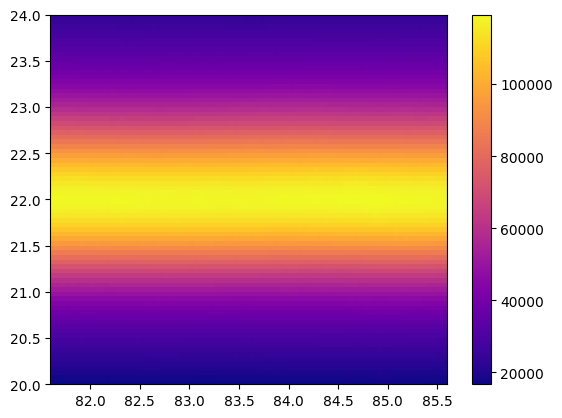

In [83]:
fig, axs = plt.subplots()
c = axs.pcolormesh(x, y, ALL_tmp_dummy, cmap="plasma")
fig.colorbar(c, orientation="vertical")


In [35]:
ALL_tmp

array([[538., 544., 543., ..., 480., 478., 479.],
       [572., 578., 578., ..., 512., 513., 509.],
       [611., 606., 605., ..., 538., 542., 540.],
       ...,
       [770., 780., 794., ..., 742., 729., 745.],
       [736., 744., 759., ..., 716., 708., 714.],
       [700., 712., 721., ..., 700., 692., 691.]])